In [130]:
import glob
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [131]:
N_REPETITIONS = 10
N_ITERATIONS = 25
FPS_VALUES = [10, 12, 14, 15, 17, 20]
rs_ver = "rs_v2"
base_path = f"data/ronin/{rs_ver}"

In [132]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'rep', 'it', 'route_id'])
    return df

In [133]:

def make_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path
    stem = Path(path).stem.split("_")
    data['fps'] = int(stem[1])
    data['highquality'] = stem[3]
    match path.split("/"):
        case ["data", "ronin", rs_ver, rep, "checkpoints", it, *objects]:
            data['rep'] = int(rep)
            data['it'] = int(it[2:])
    # print(data)

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_df(df)


dfs = []
pattern = f"{base_path}/*/checkpoints/it*/*.json"
for file in glob.glob(pattern):
    dfs.append(make_df(file))

In [134]:
df = pd.concat(dfs).sort_index()[['driving_score', 'duration_system']]
df = df.xs("True", level='highquality', drop_level=False)
# df.to_csv("df.csv")
df.reset_index().value_counts('route_id')

route_id
RouteScenario_494    7
RouteScenario_104    7
RouteScenario_625    7
RouteScenario_259    7
RouteScenario_579    7
                    ..
RouteScenario_237    1
RouteScenario_236    1
RouteScenario_233    1
RouteScenario_646    1
RouteScenario_439    1
Name: count, Length: 678, dtype: int64

In [135]:
def do_boxplot(df, column, ax=None):
    agg = df.groupby(["fps", "rep"])[column].mean()
    # use index as possition for correct spacing
    pos = agg.reset_index().groupby('fps')[column].mean().index
    agg.reset_index().boxplot(by='fps', column=column, ax=ax,
                              grid=True, positions=pos, widths=0.8)

## SOLUTIONS

In [136]:
# Get an index of minimal driving score for each fidelity value for each repetition
solutions_idx = df.groupby(
    ['fps', 'highquality', 'rep'],)['driving_score'].idxmin()
solutions = df.loc[solutions_idx][['driving_score', 'duration_system']]
solutions

driving_score  duration_system
fps highquality rep it route_id                                         
10  True        0   17 RouteScenario_311       0.075450       494.331251
                1   3  RouteScenario_337       0.059218       714.505364
                2   14 RouteScenario_278       0.054614      1497.857111
                3   17 RouteScenario_97        0.045128       412.859133
                4   15 RouteScenario_276       0.028958       483.226898
                5   20 RouteScenario_286       0.043634       492.360416
                6   21 RouteScenario_105       0.054533       503.102671
                7   7  RouteScenario_233       0.019790       625.858572
                8   10 RouteScenario_263       0.050729       722.696556
                9   18 RouteScenario_419       0.014509       479.442012
12  True        0   14 RouteScenario_59        0.033340       382.800361
                1   5  RouteScenario_595       0.070324       411.403101
                2   16 RouteScenario_99        0.031486       392.530027
                3   1  RouteScenario_337       0.044889       484.269693
                4   20 RouteScenario_262       0.078625       759.349678
                5   8  RouteScenario_337       0.041989       482.935943
                6   10 RouteScenario_107       0.030328       441.165970
                7   2  RouteScenario_263       0.052303       723.949086
                8   1  RouteScenario_602       0.113661       716.999831
                9   1  RouteScenario_69        0.099754       523.423729
14  True        0   8  RouteScenario_141       0.037605      3069.932215
                1   6  RouteScenario_342       0.033464       995.907285
                2   21 RouteScenario_248       0.008072       511.546673
                3   18 RouteScenario_392       0.004505       504.128639
                4   19 RouteScenario_298       0.129175       746.025775
                5   17 RouteScenario_395       0.066556       487.387737
                6   12 RouteScenario_77        0.183056       624.072903
                7   14 RouteScenario_160       0.047564       515.268482
                8   1  RouteScenario_263       0.050729       837.095898
                9   4  RouteScenario_742       0.445071       425.217577
15  True        0   20 RouteScenario_342       0.036013      1084.914932
                1   0  RouteScenario_408       0.169779      1000.179747
                2   18 RouteScenario_273       0.059833       974.183122
                3   24 RouteScenario_488       0.116338      3959.351618
                4   4  RouteScenario_338       0.154492      1072.434280
                5   13 RouteScenario_310       0.066807       951.577569
                6   15 RouteScenario_294       0.199386      1177.891253
                7   3  RouteScenario_245       0.039955      1937.514754
                8   2  RouteScenario_245       0.066194      1507.751883
                9   11 RouteScenario_337       0.125189      1089.106612
17  True        0   0  RouteScenario_155       0.117861      2443.535655
                1   3  RouteScenario_247       0.025977       872.051950
                2   14 RouteScenario_214       0.089366       629.804895
                3   4  RouteScenario_245       0.110324      1161.978930
                4   1  RouteScenario_717       0.600000       296.258602
                5   17 RouteScenario_159       0.143719       683.299481
                6   17 RouteScenario_140       0.303804      5721.995005
                7   10 RouteScenario_231       0.127177      1092.712209
                8   17 RouteScenario_248       0.007640       645.206162
                9   0  RouteScenario_394       0.285704       969.743690
18  True        0   13 RouteScenario_392       0.004505       635.618093
                1   2  RouteScenario_160       0.047564       641.234964
                2   2  RouteScenario_595       0.070324       585.220800
                3   17 Rout

## VERIFICATION

In [137]:
def process_verification_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop(['records', 'index'], axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['route_id'])
    return df


def make_verification_df(path: str):

    # DATA FROM PATH
    data = {}
    data['path'] = path

    # READ CHECKPOINT
    with open(path, "r") as f:
        content = json.load(f)

        data['records'] = content['_checkpoint']['records']
        if not data['records']:
            return

        df = pd.DataFrame(data)
        return process_verification_df(df)

In [138]:
dfs = []
pattern = f"{base_path}/verification/checkpoints/*/*.json"
for file in glob.glob(pattern):
    # print(file)
    dfs.append(make_verification_df(file))

oracle_df = pd.concat(dfs).sort_index()[['driving_score']]

# deduplicate
oracle_df = oracle_df.groupby(oracle_df.index).last()
oracle_df = oracle_df.rename(columns={"driving_score": "oracle_dscore"})
# oracle_df

In [139]:
joined = solutions.join(oracle_df)


joined['rmse'] = (joined['oracle_dscore'] -
                  joined['driving_score']).pow(2.0).pow(0.5)

joined

driving_score  duration_system  oracle_dscore      rmse
fps highquality rep it route_id                                                                  
10  True        0   17 RouteScenario_311       0.075450       494.331251       0.074260  0.001190
                1   3  RouteScenario_337       0.059218       714.505364       0.600000  0.540782
                2   14 RouteScenario_278       0.054614      1497.857111            NaN       NaN
                3   17 RouteScenario_97        0.045128       412.859133            NaN       NaN
                4   15 RouteScenario_276       0.028958       483.226898            NaN       NaN
                5   20 RouteScenario_286       0.043634       492.360416       1.000000  0.956366
                6   21 RouteScenario_105       0.054533       503.102671       1.000000  0.945467
                7   7  RouteScenario_233       0.019790       625.858572            NaN       NaN
                8   10 RouteScenario_263       0.050729       722.696556            NaN       NaN
                9   18 RouteScenario_419       0.014509       479.442012            NaN       NaN
12  True        0   14 RouteScenario_59        0.033340       382.800361       1.000000  0.966660
                1   5  RouteScenario_595       0.070324       411.403101            NaN       NaN
                2   16 RouteScenario_99        0.031486       392.530027            NaN       NaN
                3   1  RouteScenario_337       0.044889       484.269693       0.600000  0.555111
                4   20 RouteScenario_262       0.078625       759.349678            NaN       NaN
                5   8  RouteScenario_337       0.041989       482.935943       0.600000  0.558011
                6   10 RouteScenario_107       0.030328       441.165970       0.700000  0.669672
                7   2  RouteScenario_263       0.052303       723.949086            NaN       NaN
                8   1  RouteScenario_602       0.113661       716.999831            NaN       NaN
                9   1  RouteScenario_69        0.099754       523.423729            NaN       NaN
14  True        0   8  RouteScenario_141       0.037605      3069.932215       0.289698  0.252093
                1   6  RouteScenario_342       0.033464       995.907285       0.600000  0.566536
                2   21 RouteScenario_248       0.008072       511.546673            NaN       NaN
                3   18 RouteScenario_392       0.004505       504.128639       0.004505  0.000000
                4   19 RouteScenario_298       0.129175       746.025775            NaN       NaN
                5   17 RouteScenario_395       0.066556       487.387737       0.066556  0.000000
                6   12 RouteScenario_77        0.183056       624.072903       0.700000  0.516944
                7   14 RouteScenario_160       0.047564       515.268482       0.046386  0.001178
                8   1  RouteScenario_263       0.050729       837.095898            NaN       NaN
                9   4  RouteScenario_742       0.445071       425.217577            NaN       NaN
15  True        0   20 RouteScenario_342       0.036013      1084.914932       0.600000  0.563987
                1   0  RouteScenario_408       0.169779      1000.179747            NaN       NaN
                2   18 RouteScenario_273       0.059833       974.183122            NaN       NaN
                3   24 RouteScenario_488       0.116338      3959.351618            NaN       NaN
                4   4  RouteScenario_338       0.154492      1072.434280            NaN       NaN
                5   13 RouteScenario_310       0.066807       951.577569       0.059617  0.007190
                6   15 RouteScenario_294       0.199386      1177.891253            NaN       NaN
                7   3  RouteScenario_245       0.039955      1937.514754            NaN       NaN
                8   2  RouteScenario_245       0.066194      1507.751883            NaN       NaN
                9   11 R

## FIGURES

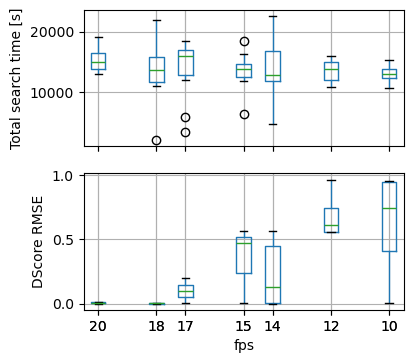

In [140]:
fig, ax = plt.subplots(nrows=2, squeeze=True, sharex=True)
fig.set_size_inches(4, 4)

# BOX PLOT FOR TOTAL TIME
total_time = df.groupby(
    ['fps', 'rep', ])['duration_system'].sum()

pos = total_time.reset_index().groupby('fps')['duration_system'].mean().index

total_time.reset_index().boxplot(by='fps', positions=pos,
                                 column='duration_system', ax=ax[0])


ax[0].set_ylabel(f"Total search time [s]")
ax[0].set_title("")
ax[0].set_xlabel("")

ax[0].invert_xaxis()

# BOX PLOT FOR RMSE

rmse = joined.groupby(['fps', 'rep', ])['rmse'].mean()

rmse.reset_index().boxplot(by='fps', positions=pos,
                           column='rmse', ax=ax[1])

ax[1].set_ylabel(f"DScore RMSE")
ax[1].set_title("")
fig.suptitle('')

fig.savefig('rs_boxplot.pdf', bbox_inches='tight')

## Number of diffrent scenarios

In [143]:
# joined.reset_index().groupby('fps').value_counts(
#     subset=['route_id']).reset_index()

In [142]:
joined = joined.reset_index()
# getting rid of "RouteScenario_"
joined['route_id'] = joined['route_id'].apply(lambda x: x.split("_")[-1])

sets = joined.reset_index().groupby(
    'fps')['route_id'].apply(list).apply(sorted)

oracle_set = sets.loc[20]
# sets = sets.apply(lambda set_x: len(set_x.intersection(oracle_set)))
sets.to_dict()

{10: ['105', '233', '263', '276', '278', '286', '311', '337', '419', '97'],
 12: ['107', '262', '263', '337', '337', '59', '595', '602', '69', '99'],
 14: ['141', '160', '248', '263', '298', '342', '392', '395', '742', '77'],
 15: ['245', '245', '273', '294', '310', '337', '338', '342', '408', '488'],
 17: ['140', '155', '159', '214', '231', '245', '247', '248', '394', '717'],
 18: ['159', '160', '160', '258', '271', '392', '408', '441', '572', '595'],
 20: ['261', '271', '297', '310', '388', '388', '391', '507', '589']}

## Similarity of diffrent scenarios